In [1]:
import numpy as np
import pandas as pd
import acquire as a 
import prepare as p
import wrangle_zillow as wz
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.impute import SimpleImputer

**1. Acquire data from mall_customers.customers in mysql database.**

In [2]:
def get_mallcustomer_data():
    df = pd.read_sql('SELECT * FROM customers;', a.get_connection('mall_customers'))
    return df.set_index('customer_id')


In [3]:
df_mall = get_mallcustomer_data()

**2. Summarize data (include distributions and descriptive statistics).**

In [4]:
a.summarize(df_mall)

Dataframe shape: 
(200, 4)
Dataframe head: 
             gender  age  annual_income  spending_score
customer_id                                            
1              Male   19             15              39
2              Male   21             15              81
3            Female   20             16               6
Dataframe info: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          200 non-null    object
 1   age             200 non-null    int64 
 2   annual_income   200 non-null    int64 
 3   spending_score  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB
None
Dataframe Description: 
                count   mean        std   min    25%   50%   75%    max
age             200.0  38.85  13.969007  18.0  28.75  36.0  49.0   70.0
annual_income   200.0  60.56  26.264721  15.0  41.50  61.5  78.0  13

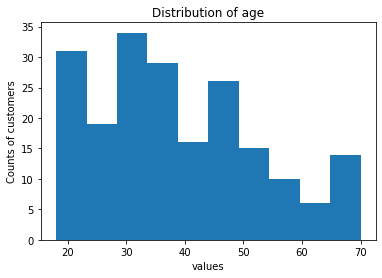

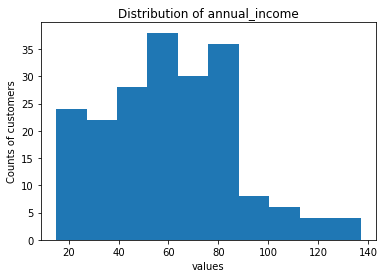

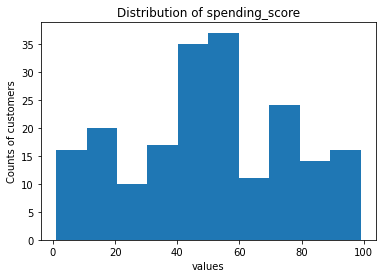

In [5]:
#distrubution of data
p.distribution(df_mall)

<AxesSubplot:title={'center':' spending_score distribution'}>

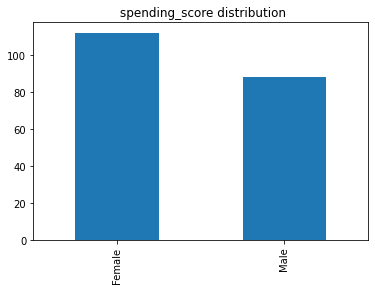

In [6]:
# vis 
df_mall['gender'].value_counts().plot(kind='bar', title = " spending_score distribution")

**3. Detect outliers using IQR.**

In [7]:
def detect_outliers(df,  k = 1.5,  drop = False):
    ''' get upper and lower bound for list of the numeric columns in a dataframe 
        if desired return that dataframe with the outliers removed
    '''
    
    odf = pd.DataFrame()
    col_list =df.select_dtypes(exclude ='O').columns.to_list()
    
    for col in col_list:

        q1, q2, q3 = df[f'{col}'].quantile([.25, .5, .75])  # get quartiles
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound
        
        # print each col and upper and lower bound for each column
        print(f"{col}: Median = {q2} lower_bound = {lower_bound} upper_bound = {upper_bound}")

        # return dataframe of outliers
        odf = odf.append(df[(df[f'{col}'] < lower_bound) | (df[f'{col}'] > upper_bound)])

        
    if drop:
        # return dataframe without outliers
        df = df[(df[f'{col}'] > lower_bound) & (df[f'{col}'] < upper_bound)]
        return df
    return odf

In [8]:
detect_outliers(df_mall, k = 1.5,  drop = False)

age: Median = 36.0 lower_bound = -1.625 upper_bound = 79.375
annual_income: Median = 61.5 lower_bound = -13.25 upper_bound = 132.75
spending_score: Median = 50.0 lower_bound = -22.625 upper_bound = 130.375


,gender,age,annual_income,spending_score
customer_id,,,,
199,Male,32,137,18
200,Male,30,137,83


In [9]:
#I have other function to remove outliers
df_mall = p.remove_outliers(df_mall, ['age', 'annual_income', 'spending_score'])

**4. Split data (train, validate, and test split)**

In [26]:
df_mall.shape
train, validate, test =p.split_data(df_mall)

train -> (110, 4)
validate -> (48, 4)
test -> (40, 4)


**5. Encode categorical columns using a one hot encoder (pd.get_dummies).**

In [27]:
dummy_train = pd.get_dummies(train[['gender']], dummy_na=False, drop_first=[True])
dummy_train.head()

,gender_Male
customer_id,
46,0
40,0
12,0
172,1
96,1


In [28]:
train= pd.concat([train, dummy_train], axis=1)
train.head(1)

,gender,age,annual_income,spending_score,gender_Male
customer_id,,,,,
46,Female,24,39,65,0


In [29]:

dummy_val = pd.get_dummies(validate[['gender']], dummy_na=False, drop_first=[True])
dummy_val.head()

,gender_Male
customer_id,
177,1
150,1
156,0
118,0
69,1


In [30]:
validate= pd.concat([validate, dummy_val], axis=1)
validate.head(1)

,gender,age,annual_income,spending_score,gender_Male
customer_id,,,,,
177,Male,58,88,15,1


In [31]:
dummy_test = pd.get_dummies(test[['gender']], dummy_na=False, drop_first=[True])
dummy_test.head()

,gender_Male
customer_id,
157,1
27,0
63,0
32,0
21,1


In [32]:
test= pd.concat([test, dummy_test], axis=1)
test.head(1)

,gender,age,annual_income,spending_score,gender_Male
customer_id,,,,,
157,Male,37,78,1,1


In [33]:
train.shape, validate.shape, test.shape

((110, 5), (48, 5), (40, 5))

In [18]:
def encoding(df, cols, drop_first=True):
    '''
    Take in df and list of columns
    add encoded columns derived from columns in list to the df
    '''
    for col in cols:
        # get dummy columns
        dummies = pd.get_dummies(df[col], drop_first=drop_first) 
        # add dummy columns to df
        df = pd.concat([df, dummies], axis=1) 
        
    return df

In [34]:
#testing  the function above
#train = encoding(train, ['gender'])

In [35]:
train.head()

,gender,age,annual_income,spending_score,gender_Male
customer_id,,,,,
46,Female,24,39,65,0
40,Female,20,37,75,0
12,Female,35,19,99,0
172,Male,28,87,75,1
96,Male,24,60,52,1


**6.Handles missing values.**

In [36]:
a.miss_dup_values(train)

Your selected dataframe has 5 columns.
There are 0 columns that have missing values.
  
** There are 0 duplicate rows that represents 0.0% of total Values**


,Missing Values,% of Total Values


In [37]:
a.miss_dup_values(validate)

Your selected dataframe has 5 columns.
There are 0 columns that have missing values.
  
** There are 0 duplicate rows that represents 0.0% of total Values**


,Missing Values,% of Total Values


In [38]:
a.miss_dup_values(test)

Your selected dataframe has 5 columns.
There are 0 columns that have missing values.
  
** There are 0 duplicate rows that represents 0.0% of total Values**


,Missing Values,% of Total Values


**7. Scaling**

In [39]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

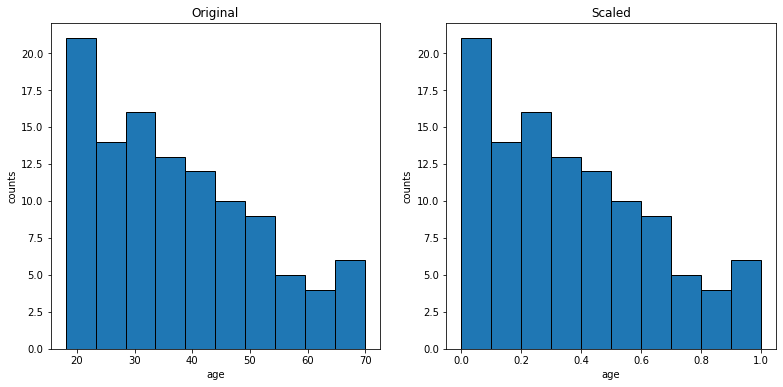

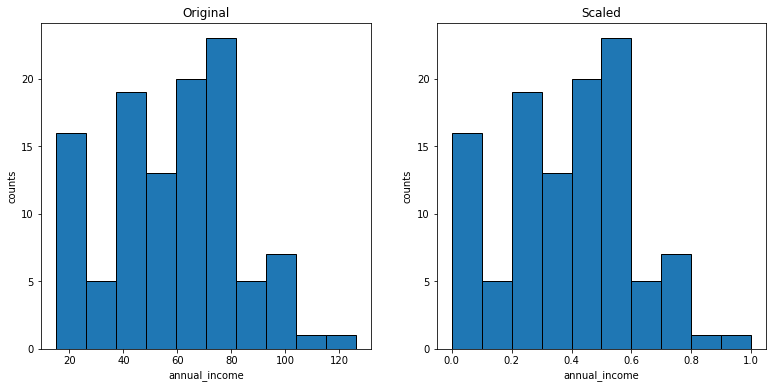

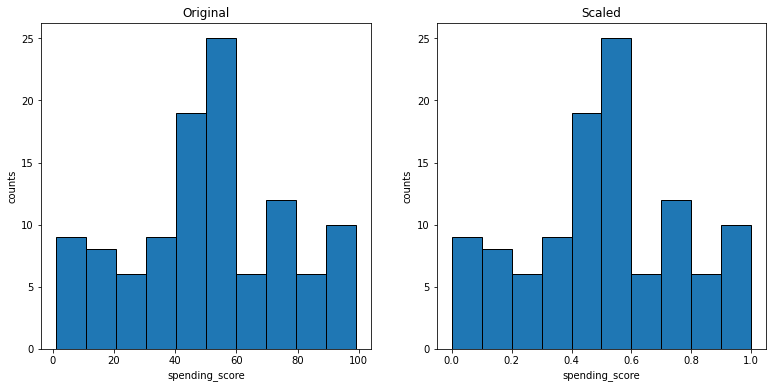

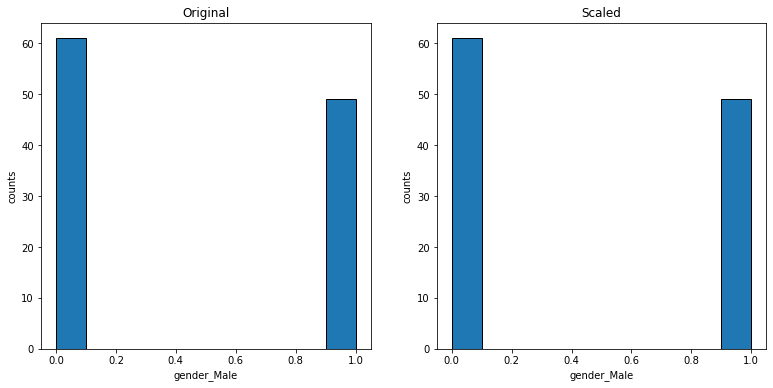

In [40]:
train_scaled , validate_validate_scaled , test_scaled = p.scaled_df( train , validate , test,  MinMaxScaler())

In [41]:
train_scaled.head()

,age,annual_income,spending_score,gender_Male
46,0.115385,0.216216,0.653061,0.0
40,0.038462,0.198198,0.755102,0.0
12,0.326923,0.036036,1.000000,0.0
172,0.192308,0.648649,0.755102,1.0
96,0.115385,0.405405,0.520408,1.0


### wrangle_mall.py

1. Acquire data from mall_customers.customers in mysql database.
2. Split the data into train, validate, and split
3. One-hot-encoding (pd.get_dummies)
4. Missing values
5. Scaling

In [42]:
def wrangle_mall():
    #acquire data
    df= get_mallcustomer_data()
    print('df shape', df.shape)
    
    #remove outliers
    df = p.remove_outliers(df, ['age', 'annual_income', 'spending_score'])
    print('df shape after removing outliers', df.shape)
    
    #split data (use my function that is prepare.py)
    train, validate, test =p.split_data(df)
    
    #encode data
    #train
    train = encoding(train, ['gender'])
    #validate
    validate = encoding(validate, ['gender'])
    #test
    test = encoding(test, ['gender'])
    
    #scaling (use my function that is prepare.py)
    train_scaled , validate_scaled , test_scaled = p.scaled_df( train , validate , test,  MinMaxScaler())
    
    return train , validate , test, train_scaled , validate_scaled , test_scaled

    

df shape (200, 4)
df shape after removing outliers (198, 4)
train -> (110, 4)
validate -> (48, 4)
test -> (40, 4)


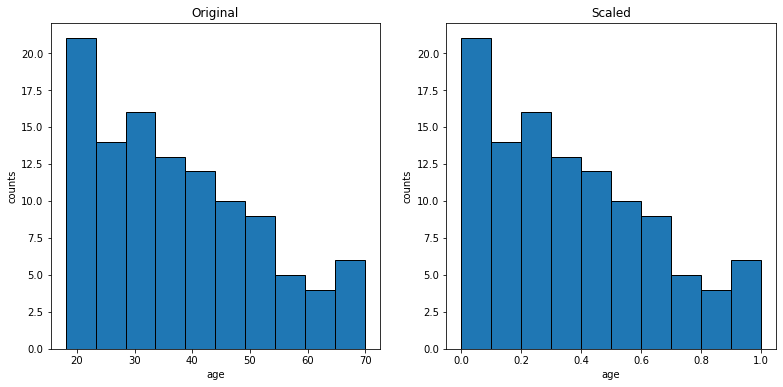

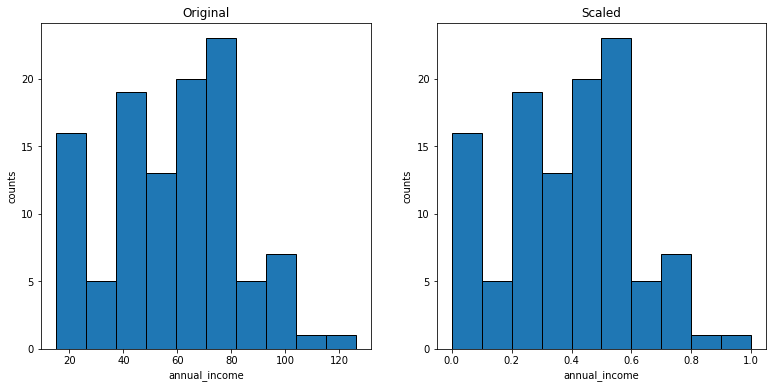

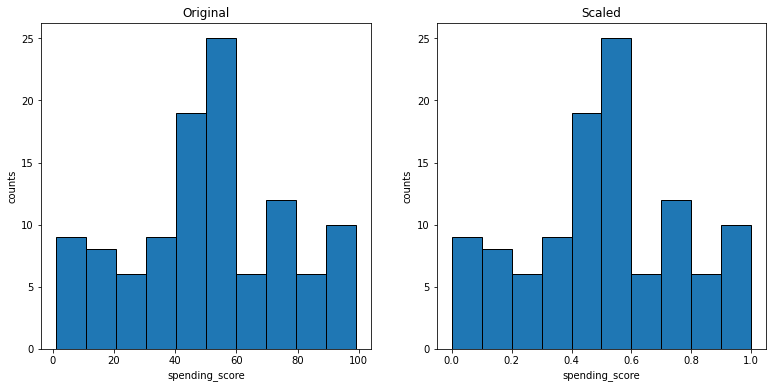

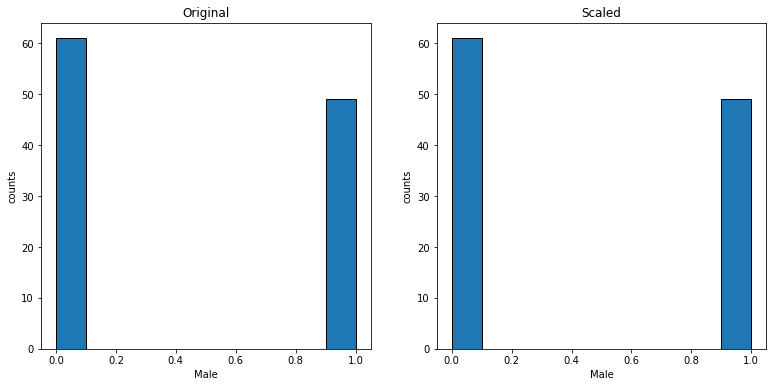

In [43]:
    
train , validate , test, train_scaled , validate_scaled , test_scaled = wrangle_mall()

df shape (200, 4)
df shape after removing outliers (198, 4)
train -> (110, 4)
validate -> (48, 4)
test -> (40, 4)


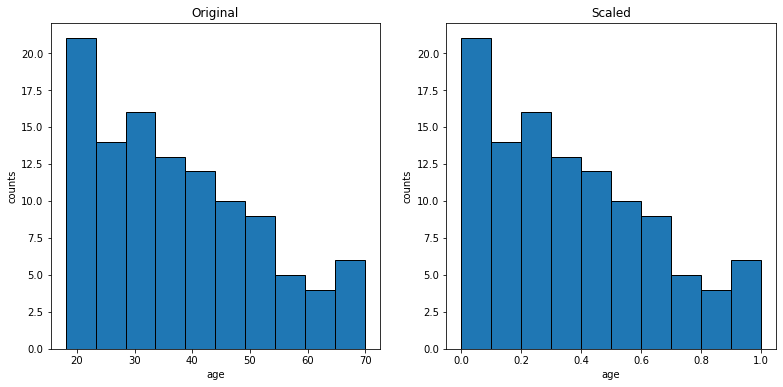

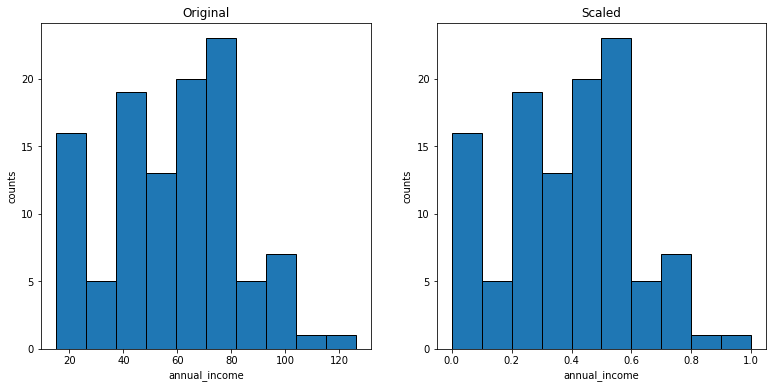

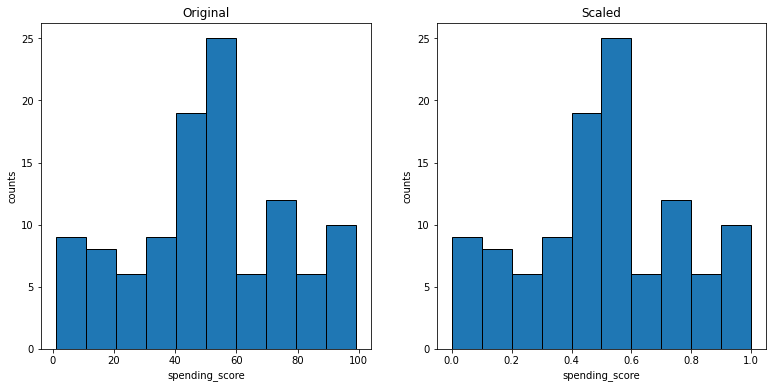

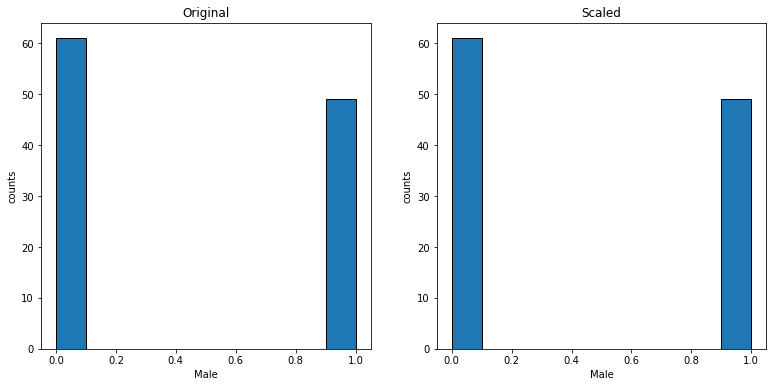

In [44]:
import wrangle_mall as wm

train , validate , test, train_scaled , validate_scaled , test_scaled= wm.wrangle_mall()
